In [12]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/ikea/GraphLearn/example


In [13]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice


def clean(graphs):
    for g in graphs:
        for n,d in g.nodes(data=True):
            d.pop('weight')
        yield g

def get_graphs(dataset_fname='bursi.pos.gspan', size=100):
    return  clean(islice(gspan_to_eden(dataset_fname),size))


#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 


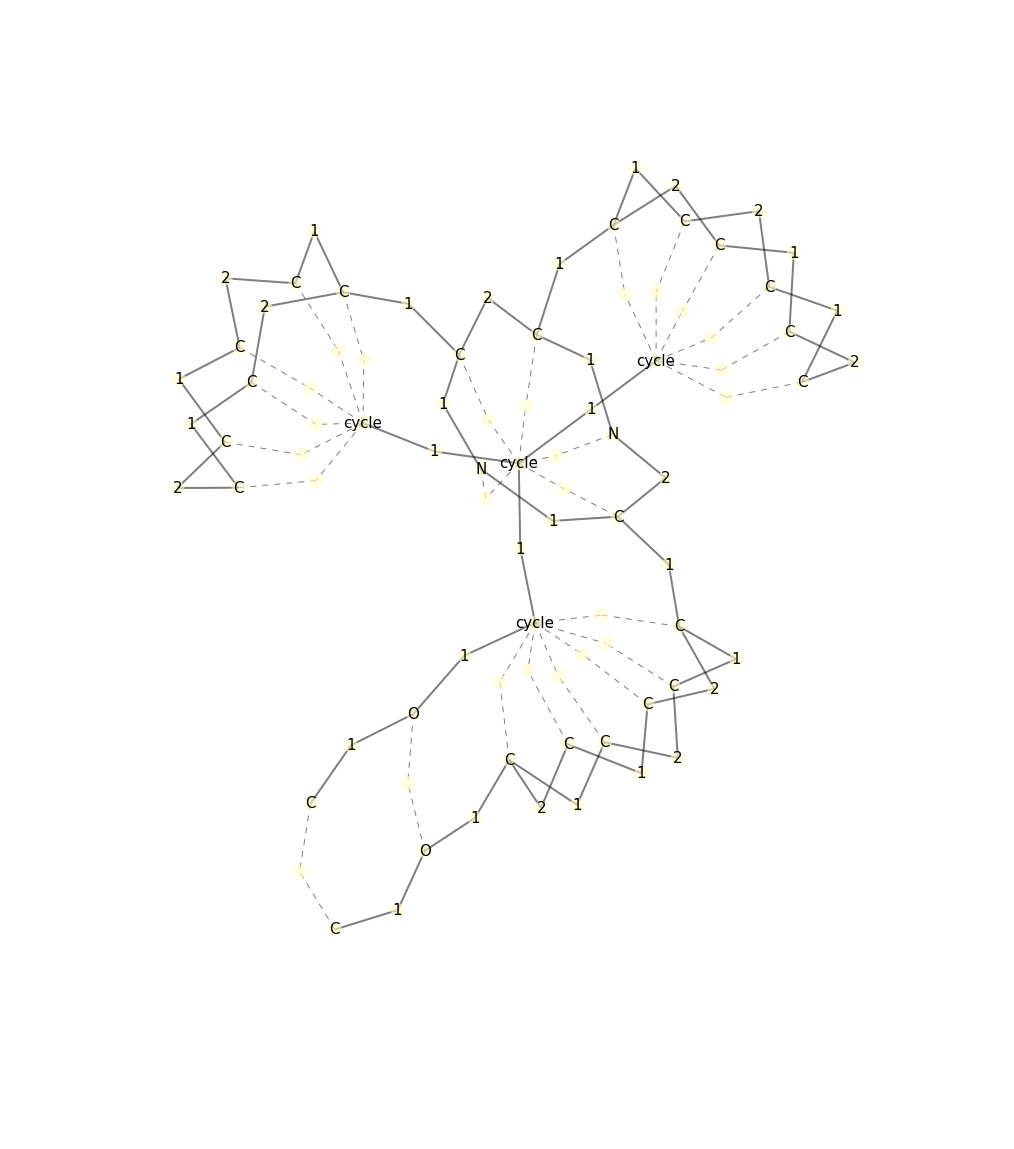

KeyError: 'neighborhood_graph_hash'

In [15]:
'''DEBUGGING VECTORIZA'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.molecules as mole
from graphlearn.graphlearn import GraphLearnSampler as GLS
from eden.graph import Vectorizer

vectorizer=Vectorizer()
graphs=get_graphs()
g=graphs.next()
g=vectorizer._graph_preprocessing(g)


gm=mole.MolecularGraphWrapper(g,vectorizer,base_thickness_list=[2])
gn=gm.graph(nested=True)

#gn=vectorizer._graph_preprocessing(gn)
#gn=vectorizer._edge_to_vertex_transform(gn)
draw.graphlearn(gn,size=20)
v=vectorizer.transform_single(gn)

In [ ]:
'''TESTING EXTRACTION AND GRAPHMANAGER'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.molecules as mole
from graphlearn.graphlearn import GraphLearnSampler as GLS
from eden.graph import Vectorizer

vectorizer=Vectorizer()

print 'DEMONSTRATING GRAPH MANAGER'
graphs=get_graphs()

for i in range(2):
    print 'grammar example %d' % i
    g=graphs.next()
    gm=mole.MolecularGraphWrapper(g,vectorizer,base_thickness_list=[2])
    #g=gm.graph(nested=True)
    #print g.nodes(data=True)
    #g.node[0].pop('weight')
    #vec=vectorizer.transform_single(g)
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)

    
print 'DEMONSTRATING EXTRACTION'  
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
argz=(gm,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)

cips=gm.all_core_interface_pairs(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
draw.graphlearn(cips[0][0].graph, contract=False)


g=gm.graph(nested=False)
print 'test', g.nodes(data=True)[0][1]
#g.node[0].pop('weight')
vec=vectorizer.transform_single(g)

In [15]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.molecules as mole
from graphlearn.graphlearn import GraphLearnSampler as GLS
graphs = get_graphs()
sampler=GLS(radius_list=[0,1],thickness_list=[1], min_cip_count=1, min_interface_count=2, graphwrapper=mole.GraphWrapper(base_thickness_list=[2]))
sampler.fit(graphs,n_jobs=1,batch_size=1)
sampler.save('tmp/mole_ubergrammar.ge')




KeyError: 'neighborhood_graph_hash'

In [ ]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=True,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

    

In [ ]:
%%time
'''
Molecule sampling
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.molecules as mole
import itertools
#sampler=mole.MolecularSampler()
#sampler.load('tmp/mole_ubergrammar.ge')
graphs = get_graphs()

id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100

graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=4,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=False,
                        burnin=0,
                        improving_threshold=0.5,
                        max_core_size_diff=5,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        omit_seed=False)

 
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    

    path_graphs= list(path_graphs)
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=5, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label',
                          headlinehook= draw.get_score_of_graph
                          )
    

In [ ]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

In [ ]:

import networkx as nx
import graphlearn.utils.draw as draw
from eden.graph import Vectorizer

v=Vectorizer()
def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

g=getpathgraph("ABC")

g= v._edge_to_vertex_transform(g)

draw.graphlearn_draw(g,contract=False,show_direction=True)

g2=nx.DiGraph(g)
#draw.display(g2,contract=False,vertex_label='id')

for n,d in g2.nodes(data=True):
    if 'edge' in d:
        if d['label']=='.':
            ns=g2.neighbors(n)
            g2.remove_edge(ns[1],n)
            g2.remove_edge(n,ns[0])
          
       
#g2 = g2.to_undirected()
draw.graphlearn_draw(g2,contract=False,vertex_label='id',show_direction=True)
g2.edges()
for n in g2.nodes():
    print n,g2.neighbors(n)
print isinstance(g2, nx.DiGraph) 

In [ ]:
g2.edges(0,data=True)

In [ ]:
asd = g2.subgraph(range(2)).copy()

In [ ]:
class A(object):
    def __init__(self,a=123):
        self.a=a
        
        
class B(A):
    def __init__(self,b=122):
        super(B,self).__init__(b)
        
        

class C(A):
    def __init__(self,c=121):
        super(C,self).__init__(c)
        
        
c=C()
c.a
        
        
        
    
    

In [2]:
import networkx as nx 

dg= nx.DiGraph()
type(dg) == nx.DiGraph

True

In [ ]:
# testin cycle stuff
import networkx as nx
import graphlearn.utils.draw as draw
import graphlearn.feasibility as feas
from eden.graph import Vectorizer
v=Vectorizer()
%matplotlib inline


def find_all_cycles(G, source=None, cycle_length_limit=None):
    """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
    types which work with min() and > ."""
    if source is None:
        # produce edges for all components
        nodes=[i[0] for i in nx.connected_components(G)]
    else:
        # produce edges for components with source
        nodes=[source]
    # extra variables for cycle detection:
    cycle_stack = []
    output_cycles = set()
    
    def get_hashable_cycle(cycle):
        """cycle as a tuple in a deterministic order."""
        m = min(cycle)
        mi = cycle.index(m)
        mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
        if cycle[mi-1] > cycle[mi_plus_1]:
            result = cycle[mi:] + cycle[:mi]
        else:
            result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
        return tuple(result)
    
    for start in nodes:
        if start in cycle_stack:
            continue
        cycle_stack.append(start)
        
        stack = [(start,iter(G[start]))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                
                if child not in cycle_stack:
                    cycle_stack.append(child)
                    stack.append((child,iter(G[child])))
                else:
                    i = cycle_stack.index(child)
                    if i < len(cycle_stack) - 2: 
                      output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                
            except StopIteration:
                stack.pop()
                cycle_stack.pop()
    
    return [list(i) for i in output_cycles]


def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

#g=getpathgraph("ABC")

#g= v._edge_to_vertex_transform(g)

#draw.graphlearn_draw(g,contract=False,show_direction=True)


#draw.display(g2,contract=False,vertex_label='id')

g=nx.cycle_graph(10)
g.add_edge(2,7)
g.add_edge(10,0)

draw.graphlearn_draw(g, vertex_label='id')


feas.rooted_problem_cycle(g,2,4)

In [ ]:
"""
proving my point ..  about tee
"""
%time
def getit():
    for x in xrange(9999999999):
        yield x
        
import itertools
g=getit()
a,b= itertools.tee(g)

for i in xrange(99999999):
    z=a.next()





In [4]:
from eden.graph import Vectorizer
import networkx as nx
from graphlearn.utils import draw

# create graph, label everything
g=nx.cycle_graph(5)
for n,d in g.nodes(data=True):
    d['label']=str(n)
for a,b,d in g.edges(data=True):
    d['label']='edge'
    
# get a vectorizer
vec=Vectorizer()

# alter graph a little
g=vec._edge_to_vertex_transform(g)

g.add_node(100, label='ubernode',node=True)
g.add_node(110, label='ubernode',edge=True)
g.add_node(111, label='ubernode',edge=True)


g.add_edge(100,110,nesting=True,label='edge')
g.add_edge(100,111,nesting=True,label='edge')

g.add_edge(110,0,nesting=True,label='edge')
g.add_edge(111,6,nesting=True,label='edge')



g.add_node(101, label='ubernode',edge=True)
g.add_edge(100,101)
g.add_node(102, label='ubernode',node=True)
g.add_edge(102,101)


draw.graphlearn(g, size= 20)
#g=vec._graph_preprocessing(g)
#draw.graphlearn(g)

print nx.info(g)

print type(vec.transform_single(g))




Name: 
Type: Graph
Number of nodes: 15
Number of edges: 16
Average degree:   2.1333


/home/ikea/.local/lib/python2.7/site-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 3558 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


KeyError: 'neighborhood_graph_hash'

3
((().().())) ggggFggFgggg
